# 概要

PyTorchを使ってLSTMで文章分類を実装してみた。    
LSTMに引き続き、今度はPytorchでseq2seqの実装

https://qiita.com/m__k/items/b18756628575b177b545

In [16]:
import os
from glob import glob
import pandas as pd
import numpy as np
import linecache
from IPython.display import Image
import torch
import torch.nn as nn
import torch.optim as optim

# Seq2Seqとは？
Seq2Seq(sequence to sequence)は、以下で説明するEncoderとDecoderを備えたEncoder-Decoderモデルを使って、系列データを別の系列データに変換するモデルのことを指します。  
ご想像の通り、seq2seqで翻訳をしたり、対話モデルを作ったりすることが可能になります。

## Encoder
InputData(画像、テキスト、音声、動画etc)を何かしらの(固定長)特徴ベクトルに変換する機構のことを言います。  
そのまんまですが、InputDataを抽象的なベクトルにエンコードしてるイメージ。

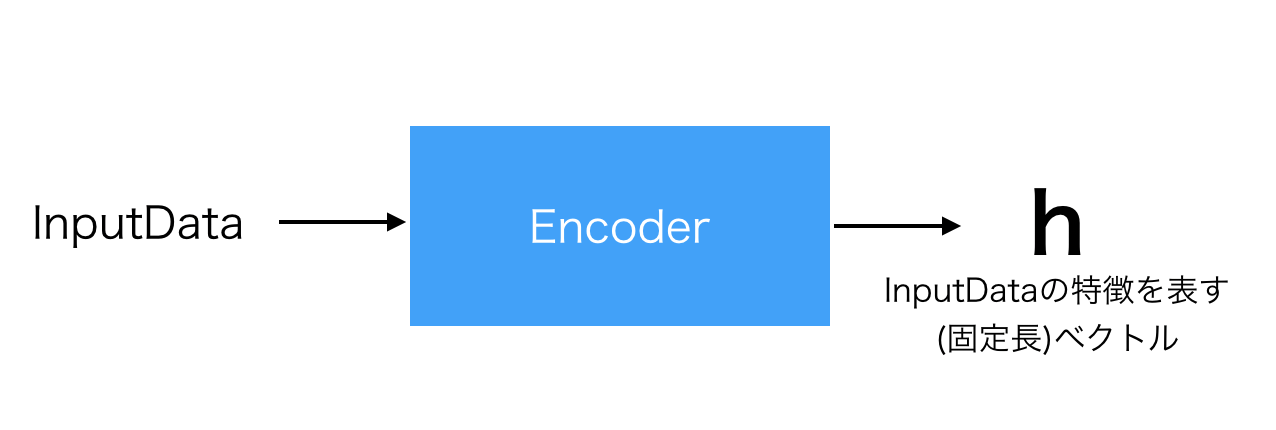

In [3]:
Image("./doc/image/encoder.png")

## Decoder
Encoderでエンコードされた特徴ベクトルをデコードして何か新しいデータを生む機構のことをいいます。  
OutputDataはInputDataと同じデータ形式である必要はなく、画像、テキスト、音声いろいろ

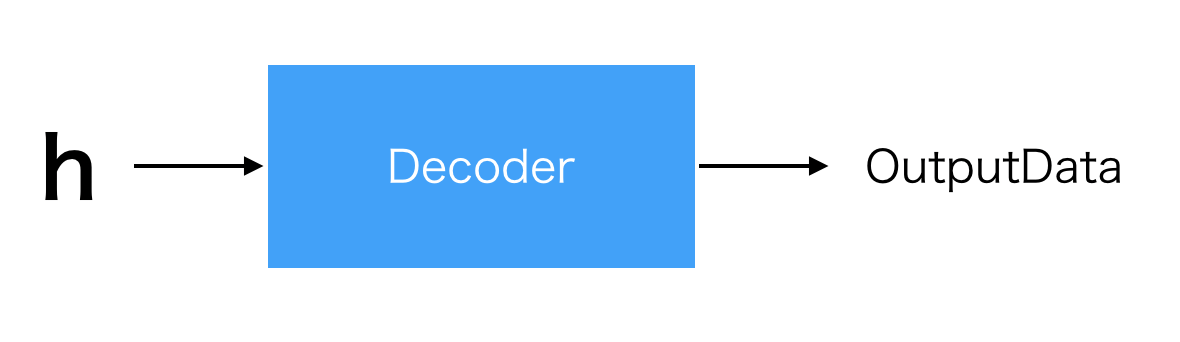

In [4]:
Image("./doc/image/decoder.png")

## Encoder-Decoderモデル
上のEncoderとDecoderをつなげると、Encoder-Decoderモデルの完成  
Encoder-Decoderモデルはいわゆる生成系のモデルであり、画像をテキストにしたり、音声からテキストを生成したり、日本語から英語（テキストから別のテキスト）に変換したりと用途は様々  

今回はこのSeq2Seqを使って系列データを別の系列データに変換するモデルを実装を通して解説してきます。

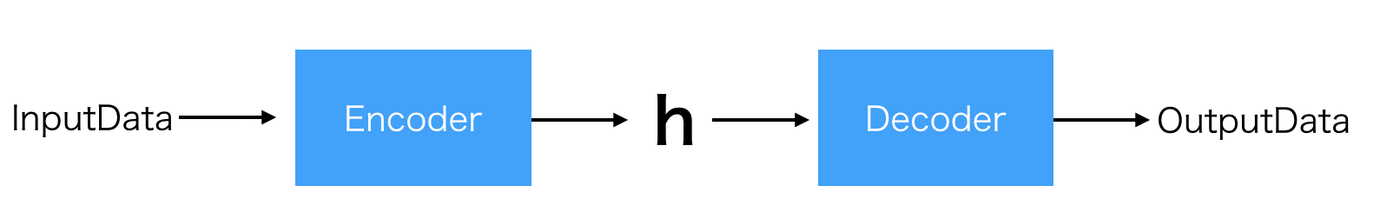

In [5]:
Image("./doc/image/encoder-decoder.png")

# 問題設定
参考記事に挙げた1.や2.で取り上げられている足し算モデルを扱おうと思ったけど、同じだと面白くないので、少し変更して最大３桁の非負整数同士の引き算をSeq2Seqに学習させてみようと思います。  
つまりどういうことかというと、「123-95」をインプットにして「28」をアウトプットに返すようなモデルを作成します。  
123-95や28を文字の系列データとみなしているわけです。系列データを扱うということはLSTMやGRUのような再帰的ニューラルネットワークが使えそうです。  
もちろん今回もバッチ化して学習させたいので系列の長さをすべて揃えます。インプットの最大の長さは「xxx - yyy」で７文字、アウトプットは負の数にもなり得るのでマイナスの記号も含めて最大４文字（ex. -457とか）となりますが、下で説明するように系列生成開始を表す文字列(ここではアンスコ"\_"とします)を１つ先頭に足す必要があるので最大５文字(_-457とか)になります。  

「123-95=28」を例に絵で書くと次のような感じ  

## Encoder
* Encoder側はいたってシンプルです。以下のようにただLSTMで最後の隠れ層のベクトルを生成すればOK。  
* LSTM層の部分はもちろんsimpleなRNNでもGRUでもOK  
* Many to One のモデルです！

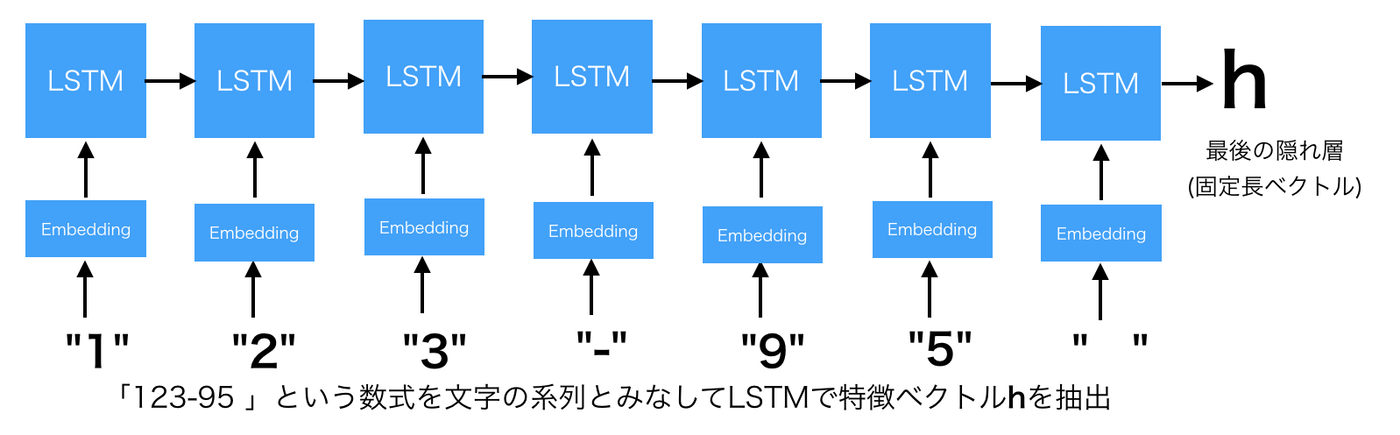

In [6]:
Image("./doc/image/encoder-many-to-one.png")

## Decoder
Decoder側がいろいろややこしいです。推論時と学習時で考え方が異なります。  
ここはゼロから作るDeep Learning ❷ ―自然言語処理編にとてもわかりやすく説明があります。下の説明もゼロ作を参考にしているので、わかりにくかったらぜひゼロ作を読んでください！  

### 推論（文字列生成）
文字列を生成方法は、以下のようにEncoderの隠れ層と文字生成開始を表す"\_"を与えて出力された文字を次のインプットの文字とし、生成された文字を次のインプットに...という操作を生成すべき文字の数だけ繰り返して実行します。

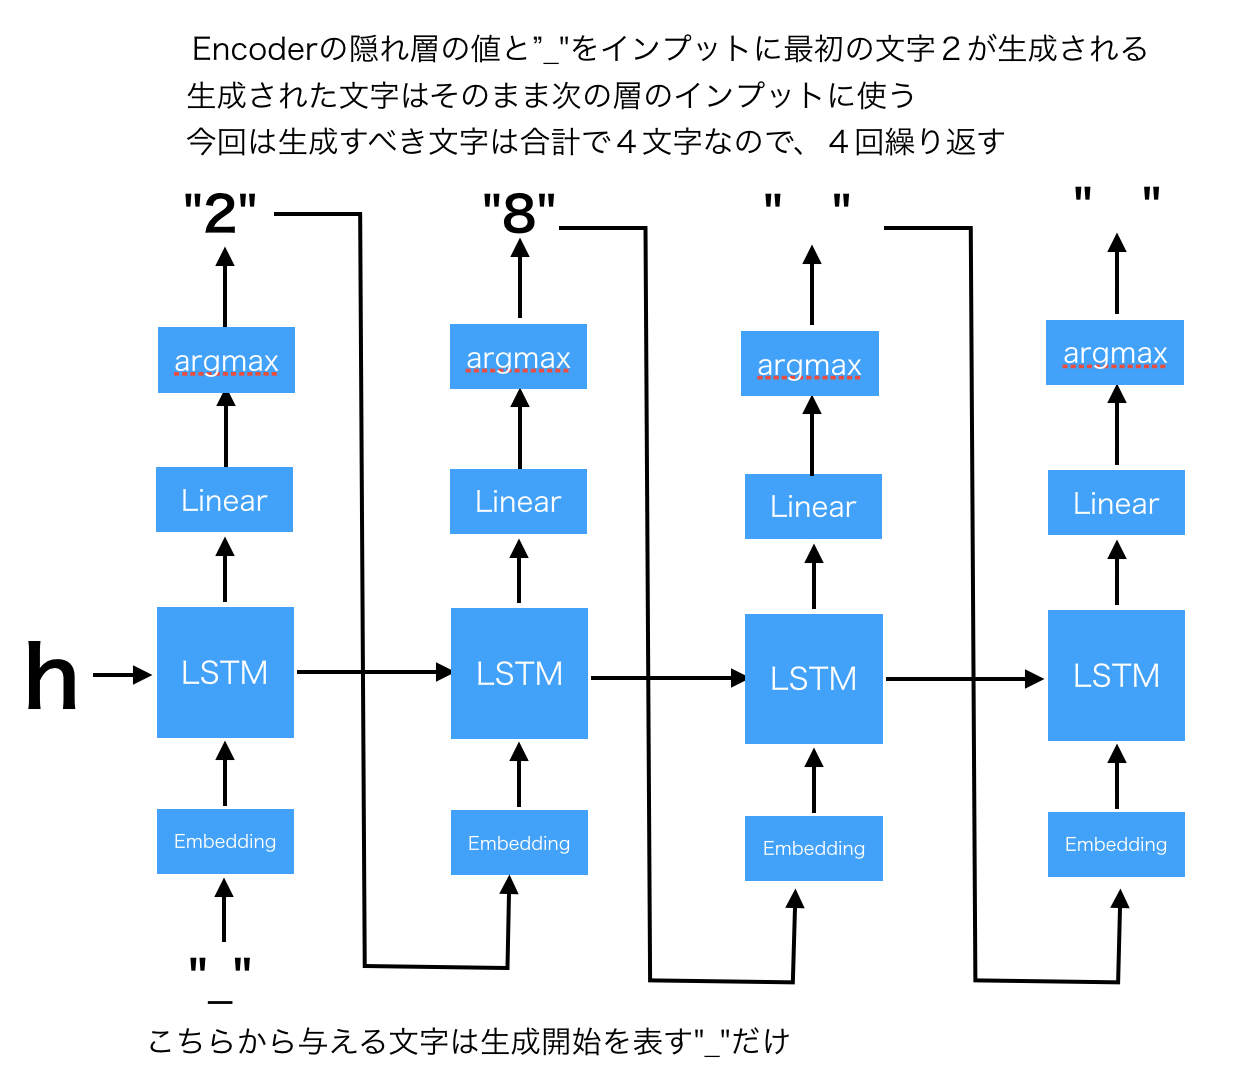

In [7]:
Image("./doc/image/decoder-predict.png")

### 学習
* 上の推論のようなモデルを作成したいわけなので、どのように学習すれば上の推論のようなことが実現できるかを考えます。
* 今回の例は答えが「"28　　"」なので、インプットは「"_"」「"2"」「"8"」「" "」の４文字をまとめて与えて、それぞれの層の結果と「"2"」「"8"」「" "」「" "」の損失を計算します。
* Linearの層の値が一番大きいものを予測値とみなせばよいので、softmaxをかます必要はありません。
* Many to Many のモデルです！

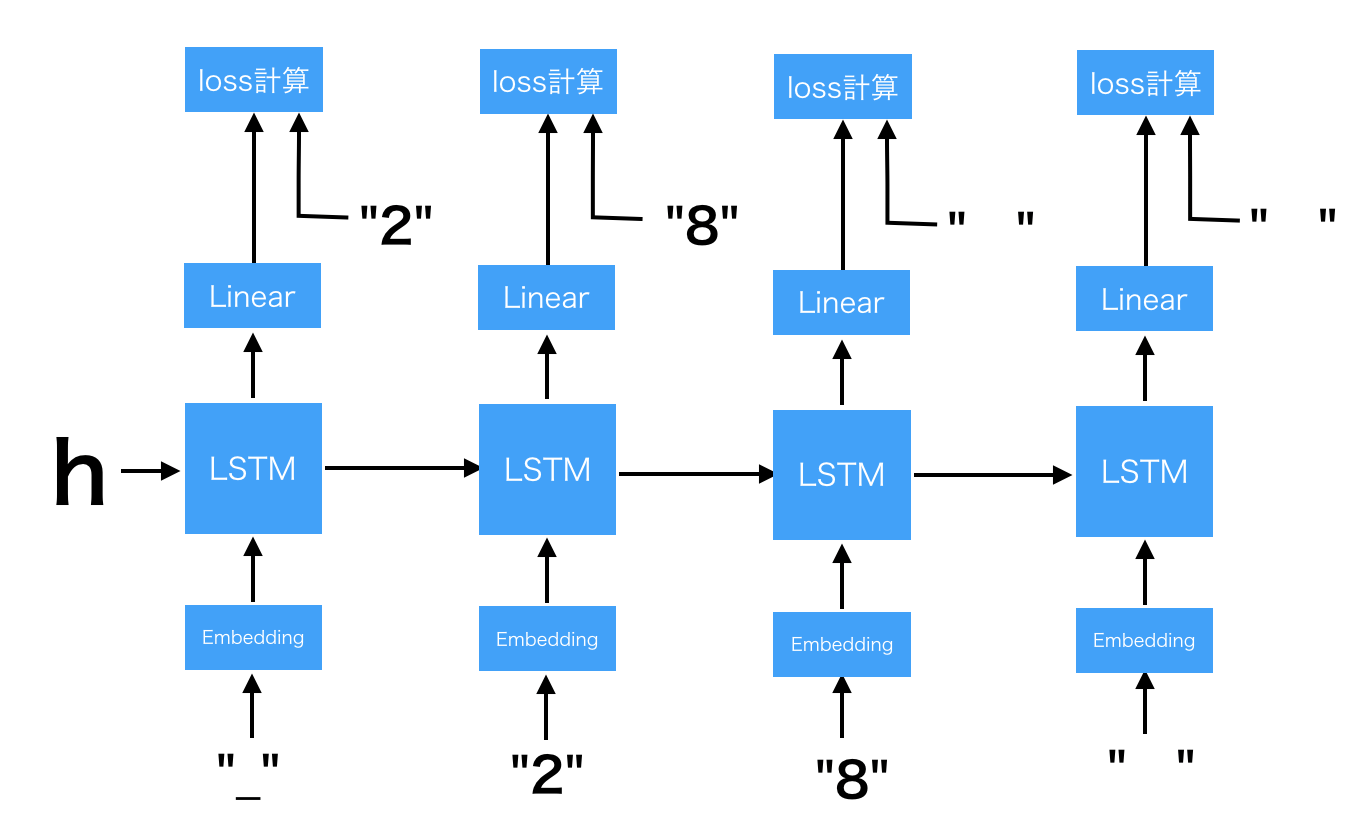

In [8]:
Image("./doc/image/decoder-fit.png")

# 実装
あとは問題設定で説明した内容をひたすら実装するだけ。  
ソースコードはPyTorchによるSeq2seqの実装をがっつり参考にさせていただきました。
## データ準備
引き算データセットの準備はどこかから入手する必要もなく、自前で準備すればOK。

In [10]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

# 数字の文字をID化
char2id = {str(i) : i for i in range(10)}
char2id

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [11]:
# 空白(10)：系列の長さを揃えるようのパディング文字
# -(11)：マイナスの文字
# _(12)：系列生成開始を知らせる文字
char2id.update({" ":10, "-":11, "_":12})
char2id

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 ' ': 10,
 '-': 11,
 '_': 12}

In [12]:
# 空白込みの３桁の数字をランダムに生成
def generate_number():
    number = [random.choice(list("0123456789")) for _ in range(random.randint(1, 3))]
    return int("".join(number))

# 確認
print(generate_number())

877


In [13]:
# 系列の長さを揃えるために空白パディング
def add_padding(number, is_input=True):
    number = "{: <7}".format(number) if is_input else "{: <5s}".format(number)
    return number

# 確認
num = generate_number()
print("\"" + str(add_padding(num)) + "\"")

"95     "


In [14]:
# データ準備
input_data = []
output_data = []

# データを５００００件準備する
while len(input_data) < 50000:
    x = generate_number()
    y = generate_number()
    z = x - y
    input_char = add_padding(str(x) + "-" + str(y))
    output_char = add_padding("_" + str(z), is_input=False)

    # データをIDにに変換
    input_data.append([char2id[c] for c in input_char])
    output_data.append([char2id[c] for c in output_char])

# 確認
print(input_data[987])
print(output_data[987])

[5, 2, 11, 3, 4, 10, 10]
[12, 1, 8, 10, 10]


In [15]:
# ７：３にデータをわける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)

## モデル定義
### Encoder
Encoderは簡単。隠れ層を返すだけでOK。  
ちょっと気にしているのが今回はLSTMの第二戻り値 (h,c) をまとめて使っています。 h だけでいいのか c もいるのか、むしろいらないのかは、まだよくわかっていません...

In [17]:
embedding_dim = 200 # 文字の埋め込み次元数
hidden_dim = 128 # LSTMの隠れ層のサイズ
vocab_size = len(char2id) # 扱う文字の数。今回は１３文字

# GPU使う用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
# Encoderクラス
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        # Many to Oneなので、第２戻り値を使う
        _, state = self.lstm(embedding)
        # state = (h, c)
        return state

### Decoder
Decoderの予測値は最大値をそのまま使えばいいので、softmaxは不要

In [21]:
## Decoderクラス
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # LSTMの128次元の隠れ層を13次元に変換する全結合層
        self.hidden2linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, sequence, encoder_state):
        embedding = self.word_embeddings(sequence)
        # Many to Manyなので、第１戻り値を使う。
        # 第２戻り値は推論時に次の文字を生成するときに使います。
        output, state = self.lstm(embedding, encoder_state)
        output = self.hidden2linear(output)
        return output, state

# モデル宣言、損失関数、最適化

In [20]:
# GPU使えるように。
encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

# 学習
Decoderの部分が参考にしている記事とちょっと違うけど、PyTorchの仕様的にこれでいいよね？

In [23]:
BATCH_NUM = 100
EPOCH_NUM = 200

all_losses = []
print("training ...")
for epoch in range(1, EPOCH_NUM+1):
    epoch_loss = 0 # epoch毎のloss

    # データをミニバッチに分ける
    input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)

    for i in range(len(input_batch)):

        # 勾配の初期化
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device)
        output_tensor = torch.tensor(output_batch[i], device=device)

        # Encoderの順伝搬
        encoder_state = encoder(input_tensor)

        # Decoderで使うデータはoutput_tensorを１つずらしたものを使う
        # Decoderのインプットとするデータ
        source = output_tensor[:, :-1]

        # Decoderの教師データ
        # 生成開始を表す"_"を削っている
        target = output_tensor[:, 1:]

        loss = 0
        # 学習時はDecoderはこのように１回呼び出すだけでグルっと系列をループしているからこれでOK
        # sourceが４文字なので、以下でLSTMが4回再帰的な処理してる
        decoder_output, _ = decoder(source, encoder_state)
        # decoder_output.size() = (100,4,13)
        # 「13」は生成すべき対象の文字が13文字あるから。decoder_outputの3要素目は
        # [-14.6240,  -3.7612, -11.0775,  ...,  -5.7391, -15.2419,  -8.6547]
        # こんな感じの値が入っており、これの最大値に対応するインデックスを予測文字とみなす

        for j in range(decoder_output.size()[1]):
            # バッチ毎にまとめてloss計算
            # 生成する文字は4文字なので、4回ループ
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()

        # 誤差逆伝播
        loss.backward()

        # パラメータ更新
        # Encoder、Decoder両方学習
        encoder_optimizer.step()
        decoder_optimizer.step()

    # 損失を表示
    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
    if epoch_loss < 1: break
print("Done")

training ...
Epoch 1: 9.46
Epoch 2: 5.62
Epoch 3: 3.44
Epoch 4: 2.78
Epoch 5: 2.43
Epoch 6: 2.16
Epoch 7: 1.95
Epoch 8: 3.06
Epoch 9: 137.11
Epoch 10: 28.41
Epoch 11: 11.13
Epoch 12: 4.61
Epoch 13: 2.99
Epoch 14: 2.42
Epoch 15: 2.10
Epoch 16: 1.87
Epoch 17: 1.67
Epoch 18: 1.52
Epoch 19: 1.38
Epoch 20: 1.25
Epoch 21: 1.15
Epoch 22: 139.87
Epoch 23: 43.07
Epoch 24: 15.35
Epoch 25: 5.85
Epoch 26: 3.19
Epoch 27: 2.31
Epoch 28: 1.90
Epoch 29: 1.66
Epoch 30: 1.48
Epoch 31: 1.32
Epoch 32: 1.19
Epoch 33: 1.07
Epoch 34: 0.97
Done


## 損失可視化
いい感じに損失減ってますが、最後らへんがちょっと迷った感じ？もう少し学習回数増やしたほうが良さそう

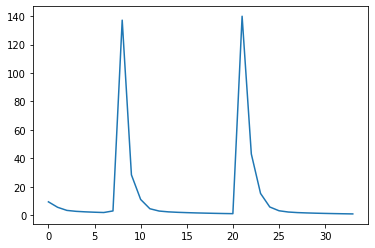

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

# 予測
ここらへんから完全に我流で書いちゃっているので急に読みにくくなるかもです...

In [25]:
# Decoderのアウトプットのテンソルから要素が最大のインデックスを返す。つまり生成文字を意味する
def get_max_index(decoder_output):
  results = []
  for h in decoder_output:
    results.append(torch.argmax(h))
  return torch.tensor(results, device=device).view(BATCH_NUM, 1)

# 評価用データ
test_input_batch, test_output_batch = train2batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
  with torch.no_grad(): # 勾配計算させない
    encoder_state = encoder(input_tensor[i])

    # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
    start_char_batch = [[char2id["_"]] for _ in range(BATCH_NUM)]
    decoder_input_tensor = torch.tensor(start_char_batch, device=device)

    # 変数名変換
    decoder_hidden = encoder_state

    # バッチ毎の結果を結合するための入れ物を定義
    batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
    # print(batch_tmp.size())
    # (100,1)

    for _ in range(5):
      decoder_output, decoder_hidden = decoder(decoder_input_tensor, decoder_hidden)
      # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
      decoder_input_tensor = get_max_index(decoder_output.squeeze())
      # バッチ毎の結果を予測順に結合
      batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)

    # 最初のbatch_tmpの0要素が先頭に残ってしまっているのでスライスして削除
    predicts.append(batch_tmp[:,1:])

# バッチ毎の予測結果がまとまって格納されてます。
print(len(predicts))
# 150
print(predicts[0].size())
# (100, 5)

150
torch.Size([100, 5])


* 上でまとめたpredictsをDataFrameにまとめるための処理を以下で実行
* ついでにaccuracyも計算

In [26]:
import pandas as pd
id2char = {str(i) : str(i) for i in range(10)}
id2char.update({"10":"", "11":"-", "12":""})
row = []
for i in range(len(test_input_batch)):
  batch_input = test_input_batch[i]
  batch_output = test_output_batch[i]
  batch_predict = predicts[i]
  for inp, output, predict in zip(batch_input, batch_output, batch_predict):
    x = [id2char[str(idx)] for idx in inp]
    y = [id2char[str(idx)] for idx in output]
    p = [id2char[str(idx.item())] for idx in predict]

    x_str = "".join(x)
    y_str = "".join(y)
    p_str = "".join(p)

    judge = "O" if y_str == p_str else "X"
    row.append([x_str, y_str, p_str, judge])
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])

# 正解率を表示
print(len(predict_df.query('judge == "O"')) / len(predict_df))
# 0.8492
# 間違えたデータを一部見てみる
print(predict_df.query('judge == "X"').head(10))


0.868
      input answer predict judge
18   955-36    919     929     X
20   74-816   -742    -732     X
26  100-769   -669    -679     X
28    213-6    207     197     X
61  195-462   -267    -227     X
76   78-327   -249    -349     X
78   80-669   -589    -599     X
80    67-27     40      30     X
82   845-13    832     822     X
85  822-199    623     633     X


* input: 予測対象
* answer: 正解
* predict: 予測結果
* judge: 予測が正しければ"O"、間違っていたら"X"

これを見る限り、なんか結果の10の桁が1つずれてしまう傾向がある気がする。人間ではしなさそうな計算ミスをしているような。

# おわりに
もっとepoch数を増やすと90数％くらいの精度まで上がります  
ゼロ作にも書いてますが、精度を更に上げるには覗き見(Peeky)という方法が有効なようです。Encoderの隠れ層をDecoderの最初の層だけに渡すのではなく、各DecoderのLSTM層すべてに渡してしまう、という方法のようです。